# Lab: Explainability in Neural Networks with activation maximitation.


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [5]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

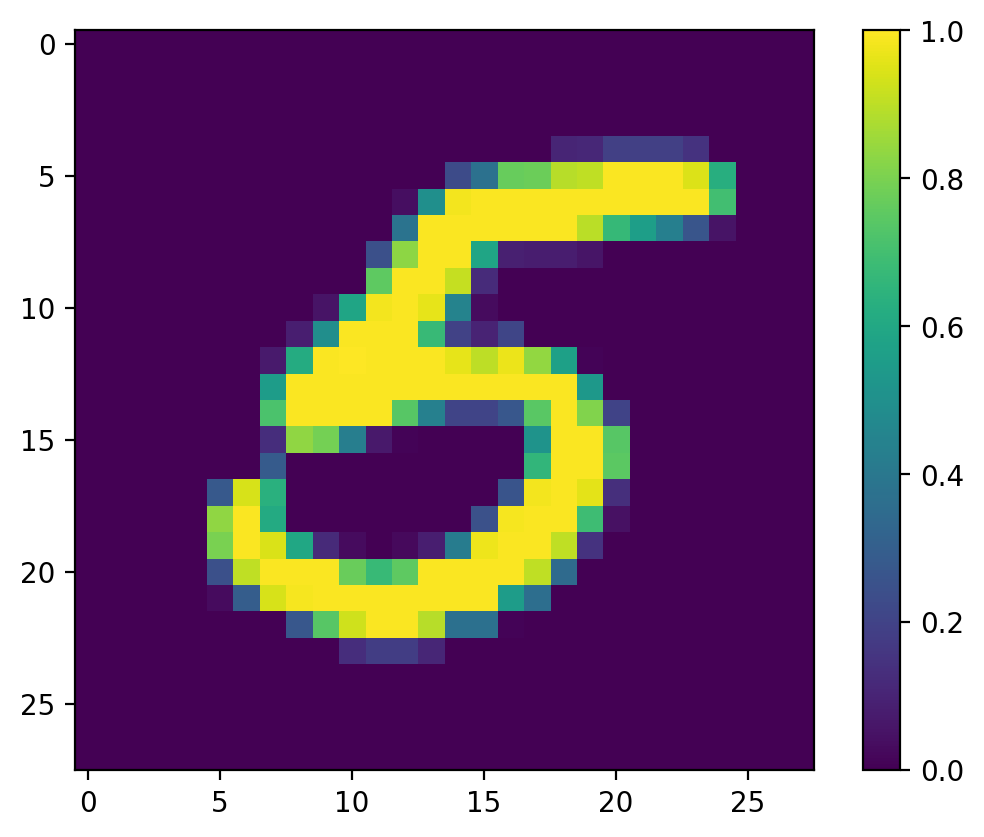

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [7]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [9]:
#YOUR CODE HERE
# Creamos un MLP con 3 capas ocultas + una salida (con 10 neuronas ya que contamos con 10 posibles clases)
# Entre capas aplicamos una ReLu (evitamos desvanecimiento de gradiente) y acabamos con una logsoftmax (para clasificación multiclase)

class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [10]:
# Introducimos el entrenamiento, el estudio del conjunto de validación y el análisis del acuraccy

class MLP_extended(MLP):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional
                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
                    
                # de esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación

                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) # actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # ploteamos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [11]:
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=3, lr=1e-3)
my_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.363042
Validation loss after 0 epochs: 0.175977

Training loss after 1 epochs: 0.137777
Validation loss after 1 epochs: 0.125026

Training loss after 2 epochs: 0.093276
Validation loss after 2 epochs: 0.116800



## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [ ]:
for param in my_MLP_drop.parameters(): #my_MLP_drop is the name of your neural network!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [ ]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]),requires_grad = True)

        self.NN_trained = NN_trained

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained.forward(#YOUR CODE HERE)
        
        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(#YOUR CODE HERE)

        # sgd_iter is the number of iterations
        
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE 
            
            # Compute the network output
            #YOUR CODE HERE
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,#YOUR CODE HERE].view(true_log_prob.shape),#YOUR CODE HERE)
  

            self.loss_during_training.append(loss)

            # Compute gradients
            #YOUR CODE HERE
          
            # Optimize
            #YOUR CODE HERE

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [ ]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

In [ ]:
#YOUR CODE HERE

> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

In [ ]:
#YOUR CODE HERE

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

In [ ]:
#YOUR CODE HERE

> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

In [ ]:
#YOUR CODE HERE

> **Exercise:** Repeat the results for all digits and discuss those results.

In [ ]:
#YOUR CODE HERE